<a href="https://colab.research.google.com/github/dalebancroft/ut-aiml/blob/main/Project%206%20-%20Natural%20Language%20Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing Necessary Libraries**

In [ ]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 17.4 MB/s eta 0:00:00


In [ ]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# to use regular expressions for manipulating text data
import re

# To used time-related functions
import time

# To parse JSON data
import json

# To remove common stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# To build, tune, and evaluate ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Loading the dataset**

In [ ]:
# Mounting Google Drive for importing data into Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import raw news article and stock price from Google Drive
stocks = pd.read_csv("/content/drive/MyDrive/Study_Materials/PGP-AIML/06.Natural_Language_Processing/Project_7_Stock_Market_Sentiment_Analysis/stock_news.csv")

In [ ]:
# Creating a copy of the raw data for modelling purposes
data = stocks.copy()

## **Data Overview**

###Step 1 - Review data sample

First a sample of the first 5 rows from the dataset will be reviewed, to observe columns and note any potential null or nonsensical values in the sample displayed.

In [ ]:
# Printing a sample of the first 5 rows from the data set
data.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


From the sample displayed, it appears that each **Date** value can have multiple rows associated with it.

All rows with the same **Date** will have identical **Open**, **High**, **Low**, **Close** and **Volume** stock data values, as these values are each calculated for a specific date.

The **News** string for each record sampled is unqieu, suggestiong that the data includes a new row for each unique news article, and multiple news articles can be published for the target company on a specific date.

Based on the **News** strings displayed, this data set appears to contain news articles and stock price movements for the technology company Apple.

There is no secondary index value included in the data set. The only index comes from the data frame generated here.

While each of the records here has a neagive sentiment **Label** value, the data dictionary suggests that netural or positive sentiment news articles should have a **Label** value of 0 or 1 respectively. This will be confirmed through further steps in the Data Overview.

No null values were identified in this initial random sample.

###Step 2 - Checking shape of the data set

In [ ]:
# Output the number of rows and columns in the data set
data.shape

(349, 8)

There are 349 records in this data set, with 8 fields per record.

###Step 3 - Checking field types and missing values

In [ ]:
# Output the data type of each field, and number of non-null values per field
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


There are 4 float fields, 2 integer fields and 2 object fields in the raw data set.
- The **Date** object field may need to be converted into a more appropriate format before model building can begin.

Each field comprises of 349 non-null values, suggesting there are no missing values to be addressed in the data set.

In [ ]:
# Confirming there are no null values in the data set
data.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


There are no missing values in the data set.

###Step 4 - Checking for duplicate values

In [ ]:
# Count how many duplicate records are present
data.duplicated().sum()

0

All 349 records are unique. There are no duplicate values.

###Step 5 - Reviewing a statistical summary

In [ ]:
# Provide average (mean) and distribution of values in each field of the data set
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,349,71,2019-01-03,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
News,349,349,The tech sector experienced a significant dec...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Open,349.0,NaN,NaN,NaN,46.229233,6.442817,37.567501,41.740002,45.974998,50.7075,66.817497
High,349.0,NaN,NaN,NaN,46.700458,6.507321,37.817501,42.244999,46.025002,50.849998,67.0625
Low,349.0,NaN,NaN,NaN,45.745394,6.391976,37.305,41.482498,45.639999,49.7775,65.862503
Close,349.0,NaN,NaN,NaN,44.926317,6.398338,36.254131,40.246914,44.596924,49.11079,64.805229
Volume,349.0,NaN,NaN,NaN,128948236.103152,43170314.918964,45448000.0,103272000.0,115627200.0,151125200.0,244439200.0
Label,349.0,NaN,NaN,NaN,-0.054441,0.715119,-1.0,-1.0,0.0,0.0,1.0


The statisical summary provides the following observations on the data set:
* **Date** is made up of 71 unique values, suggesting the data set covers 71 trading days.
  * The highest number of news articles was published on 2019-01-03, with 28 articles published that day.
* There are 349 unique **News** articles listed in the data set.
* The average stock **Open** value in the time period covered by the data set is \$46.23, and ranges between \$37.57 and \$66.82 in the time period.
  * The mean and median opening stock prices are similar, suggesting a normal distribution.
* The average stock **High** value in the time period covered by the data set is \$46.70, and ranges between \$37.82 and \$67.06 in the time period.
  * The mean and median stock price highs are similar, suggesting a normal distribution.
* The average stock **Low** value in the time period covered by the data set is \$45.74, and ranges between \$37.31 and \$65.86 in the time period.
  * The mean and median stock price lows are similar, suggesting a normal distribution.
* The average stock **Close** value in the time period covered by the data set is \$44.93, and ranges between \$36.25 and \$64.81 in the time period.
  * The mean and median stock price lows are similar, suggesting a normal distribution.
* The average **Volume** of stocks traded on a single day is 128,948,236, and ranges between 45,448,000 and 244,439,200 in the time period.
  * The mean daily **Volume** is approx. 13,321,036 higher than the median, suggesting a right-skewed distribution.
*  The average sentiment **Label** value is -0.054441, suggesting there are more negative and neutral sentiment news stories in the data set than positive news stories.
  * At least 25% of news stories in the data set have a negative sentiment.
  * At least 75% of news stories in the data set have either a negative or neutral sentiment.
  * This suggests purely positive news stories about the company in the time period are uncommon in comparison to negative or neutral sentiment stories.

## **Exploratory Data Analysis**

### Univariate Analysis

####Date

In [ ]:
# Show max and min date values
print("First Date:", data['Date'].min())
print("Last Date:", data['Date'].max())

First Date: 2019-01-02
Last Date: 2019-04-30


**Observations**

The time period covered this data set starts on January 2, 2019, and ends on April 30, 2019.

####News

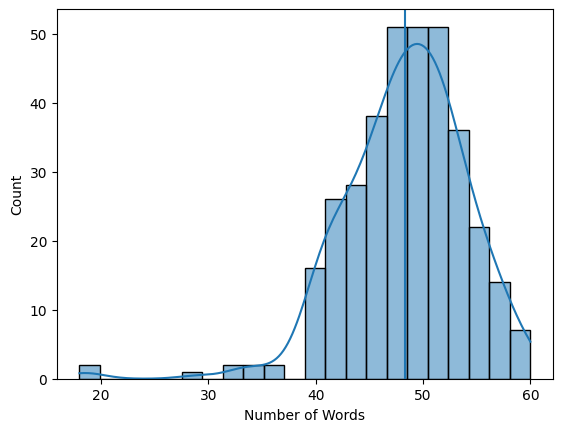

In [ ]:
# Calculate the word of each news article
data['word_count'] = data['News'].apply(lambda x: len(x.split()))

# Plot the distribution of word counts for each news article
histplot = sns.histplot(data['word_count'], kde=True, ax=plt.gca())
plt.xlabel('Number of Words')
histplot.axvline(data['word_count'].mean())
plt.show()

**Observations**

Each news article is made up of between 18 and 60 words, with an average of approx. 48 words.

At least 75% of the new articles in the data set are made up of at least 45 words.

####Stock price data - Open, High, Low, Close

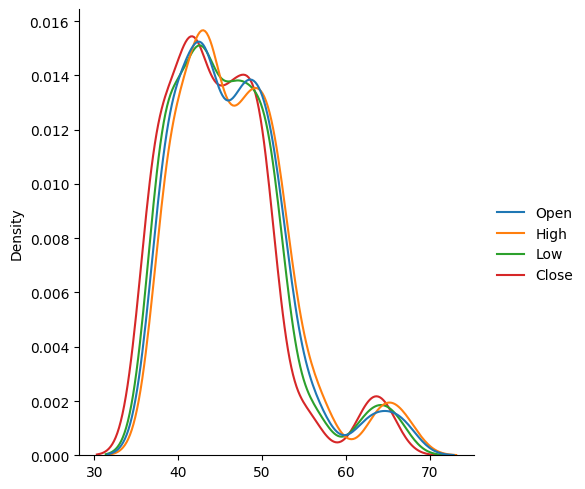

In [ ]:
# Generate a distribution plot of the open, high, low and close stock price values
sns.displot(data=data[["Open","High","Low","Close"]], kind="kde", palette="tab10");

**Observations**

All four stock price values follow a similar distribution, with the majority of dates reporting a stock price of between \$40 and \$50.

There is a smaller distribution of dates (density <= 0.002) that report stock prices of between \$60 and \$70, suggesting that there was a period of time where Apple's stock price was exceeding \$60, higher than the expected average for the time period.

These dates would potentially have provided an opportunity to sell Apple stocks at a profit, if they were purchased at their more common average price range of between \$40 and \$50.

####Volume

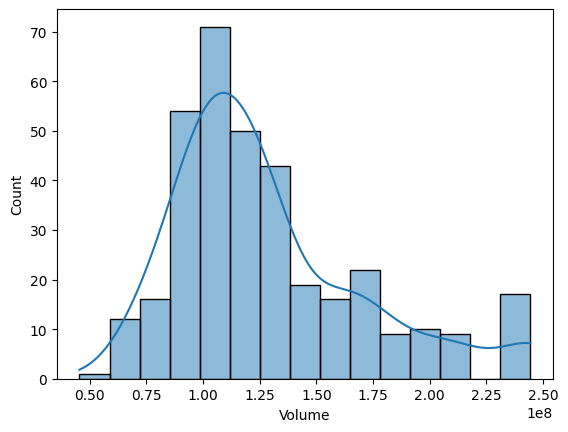

In [ ]:
# Generate a histplot summarizing the distribution of the Volume variable
sns.histplot(data, x='Volume', kde = 'True');

**Observations**

*Note* - The volume of stocks traded is measured on the y axis in increments of `1e8`, which refers to `10^8` or `100,000,000` units of stock traded.

The histplot shows that on the majority of trading days the volume of stocks traded varied between `0.9\*10^8` and `1.1\*10^8` units.

However, on almost 20 days in the data set, there was a larger volume of over `2.3\*10^8` units of stock traded. These higher than average volumes of stock traded on those days may be in response to the release of significant new information about the company's performance, which would drive an increase in stock trading volume.

####Label

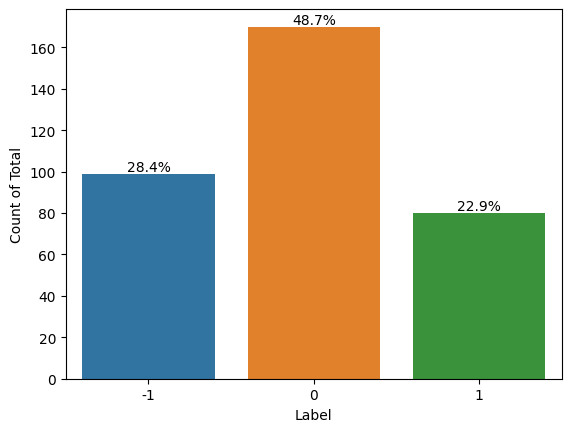

In [ ]:
# Generate a countplot of the sentiment label distribution in the stock data
ax = sns.countplot(data=data, x="Label", stat="count", palette="tab10")

# Create x and y axis labels
plt.xlabel("Label")
plt.ylabel("Count of Total")

total = len(data["Label"]) # Calculate total population of Label values
for p in ax.patches: # Iterate through each label
    percentage = '{:.1f}%'.format(100 * p.get_height()/total) # Calculate percentage of population for each label
    x = p.get_x() + p.get_width() / 2 # Identify x coordinate for label at the mid point of each bar
    y = p.get_height() # Identify y coordinate for percentage label at the top of each bar
    ax.annotate(percentage, (x, y), ha='center', va='bottom') # Apply percentage label at x and y coordinates

plt.show()

**Observations**


The countplot shows that almost half (48.7%) of all news articles in the data set have a neural sentiment label applied.

There are more negative (28.4%) sentiment labels applied than positive (22.9%) labels.

### Bivariate Analysis

####Correlation check

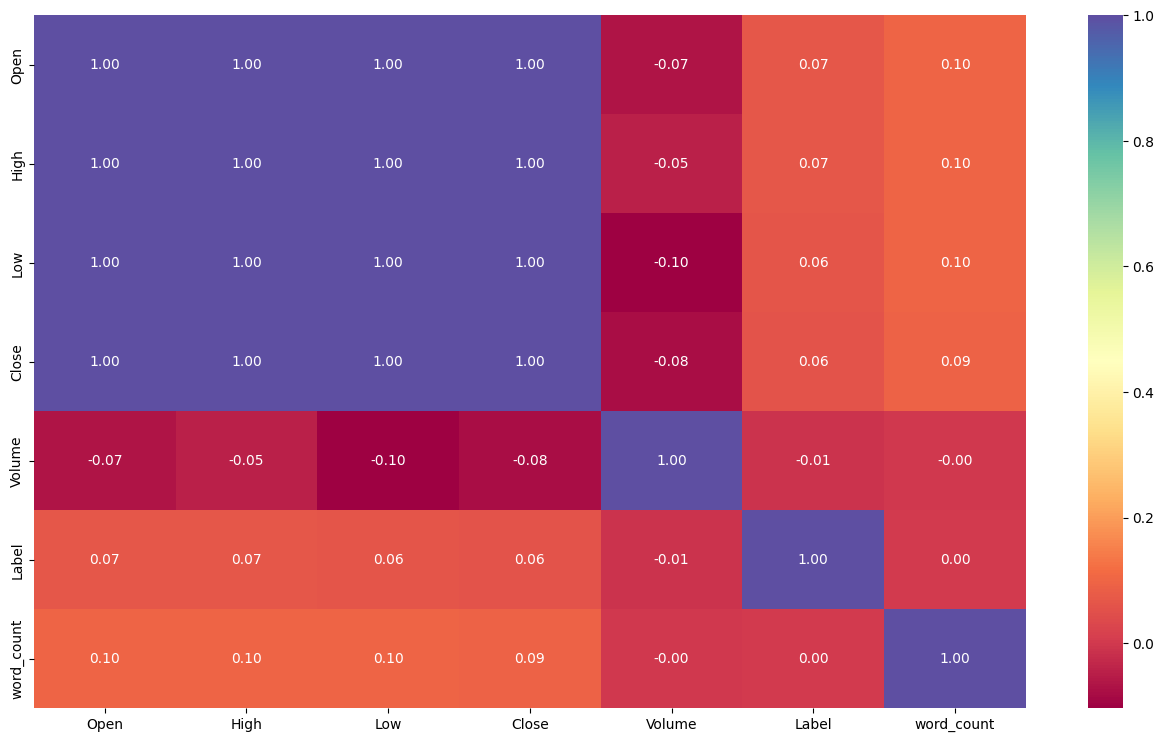

In [ ]:
# Generate a heat map of correlation between numeric values in the data set
plt.figure(figsize = (16,9))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f", cmap="Spectral");

**Observations**
* The four stock price variables of **Open**, **High**, **Low** and **Close** are perfectly correlated.
  * This demonstrates that as the overall stock price changes, it impacts all stock price benchmark variables.
* **Volume** is very slightly negatively correlated with the four stock price variables.
  * This suggests that there are higher trading volumes of the stock on days where the stock price decreases.
  * When the stock price decreases, traders may be quick to respond in order to avoid incurring a loss.
  * Conversely, when the stock price increases, traders may be slower to respond while they await further increases in stock price in order to maximize their profits.
* There is a slight (<0.1) positive correlation between the sentiment **Label** for a news story and the four stock price variables.
  * This suggests that the stock price rises when a positive news story about the company is published.
  * However, this is a weak positive correlation - the nature and content of the news story is likely a more important factor than the sentiment alone.
* There is a slightly stronger positive correlation between the **word_count** of each news article and the four stock price variables.
  * This suggests that longer positive sentiment news articles may contain more significant news stories which drive a greater increase in stock price.
* There does not appear to be any correlation between **Label**, **Volume** and **word_count**.

####Stock Price (Open, High, Low, Close) vs Label

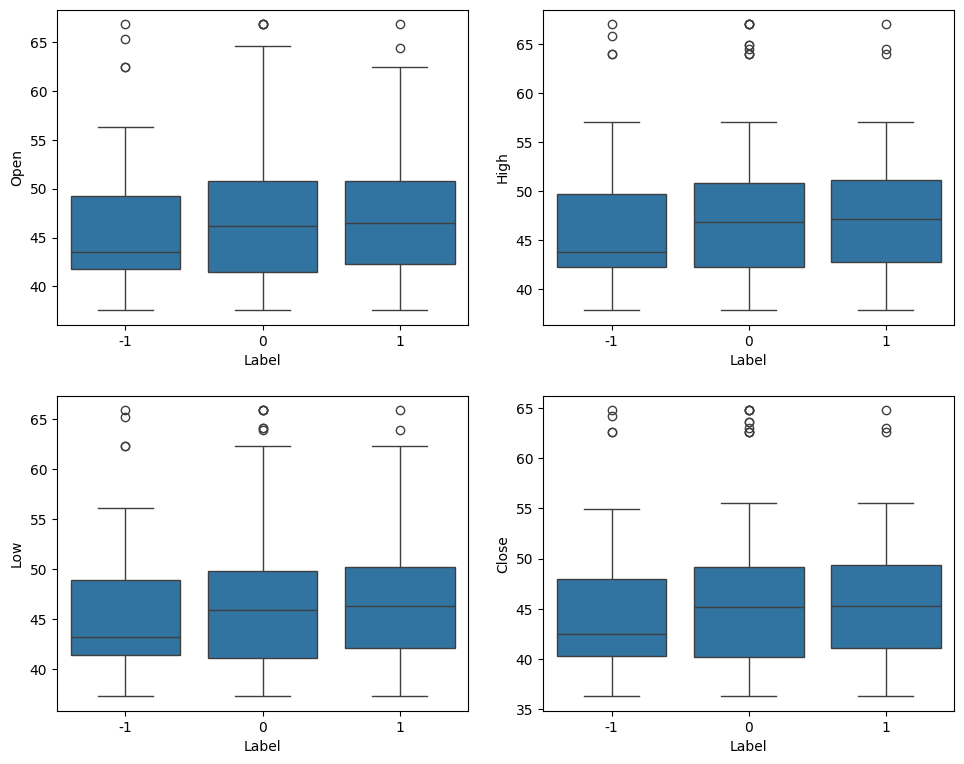

In [ ]:
# Generate a plot to display 4 subplots
plt.figure(figsize=(10, 8))

# For each stock price variable, create a boxplot showing price range for each sentiment label
for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=data, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

**Observations**
* On days with negative sentiment news stories, apart from 3 outliers the stock price did not reach higher than \$57, and did not close above \$55.
  * This suggests that, outside of the 3 outliers, that the stock price is depressed and can reach a lower low value when a negative sentiment story is published.
* The median open, high, low and close stock prices were all above \$45 on days where neutral and positive news stories were published, and below $45 on days where negative sentiment stories were published.
* Stock prices of below \$40 were seen regardless of sentiment.
* There were outlier prices of above \$60 reported for all sentiment labels.
* On 75% of days, the stock price opened and closed below \$51, regardless of sentiment label.

####Stock Price (Open, High, Low, Close) vs Date

In [ ]:
# Obtain the average stock price values for each date in the data set
stock_daily = data.groupby('Date').agg(
    {'Open': 'mean',
     'High': 'mean',
     'Low': 'mean',
     'Close': 'mean',
     'Volume': 'mean'}
).reset_index()  # Group the 'stocks' DataFrame by the 'Date' column
stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400.0
2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800.0
2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000.0
2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000.0
2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600.0


Using these average stock price values for each date, a lineplot can be drawn showing the fluctations in these stock price values over time.

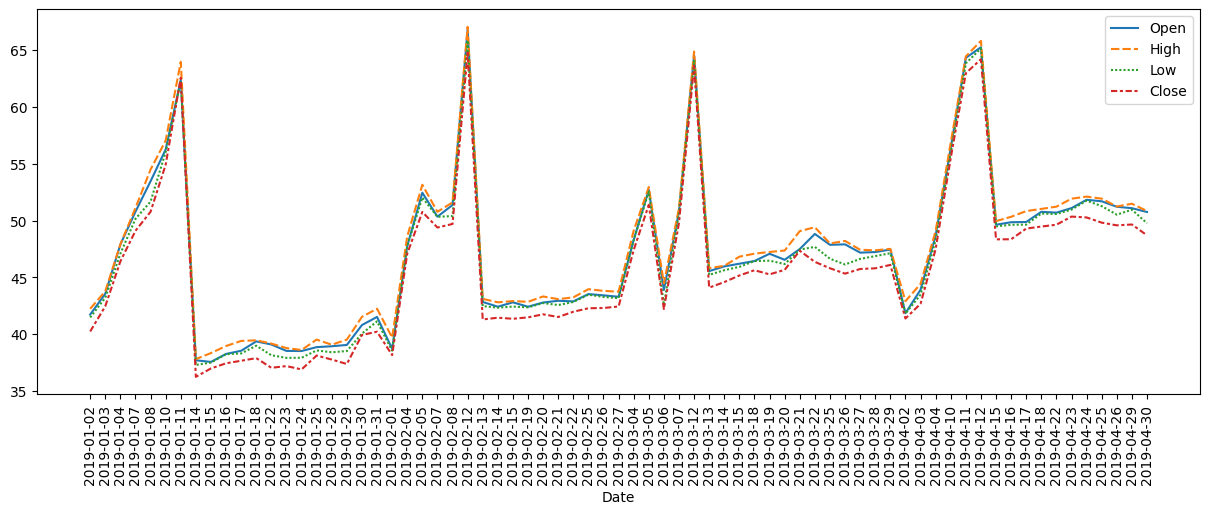

In [ ]:
# Generate a lineplot tracking the stock price values over time
plt.figure(figsize=(15,5))
sns.lineplot(stock_daily.drop("Volume", axis=1))
plt.xticks(rotation=90)
plt.show(); #Complete the code to plot a lineplot of all the variables except Volume

**Observations**
* The Open, High, Low and Close stock price values for each date track fairly closely, with limited variation.
* The difference between the High and Low stock price values on an individual day are >\$2.
* The stock prices appears to increase and descrease significantly on specific dates, suggesting large movements in value in response to specific news stories.
* The stock price appears to rise and fall consistently over time.
* The largest increase in stock value occurred on 2019-02-08 and 2019-03-12.
  * Further analysis should be performed on the news stories on this date to determine if any news story could have predicted this rapid increase in stock price value.
* Similarly, large declines in stock price value were recorded on 2019-01-10, 2019-02-12, 2019-03-12 and 2019-04-12.
  * These sharp declines all occur after a period of rapid stock price growth, suggesting a market correction caused by traders selling large volumes of overprice stock.
  * There may be negative sentiment news stories published on these days which contributed to triggering the reduction in stock price.

####Stock Price (Close) vs Volume

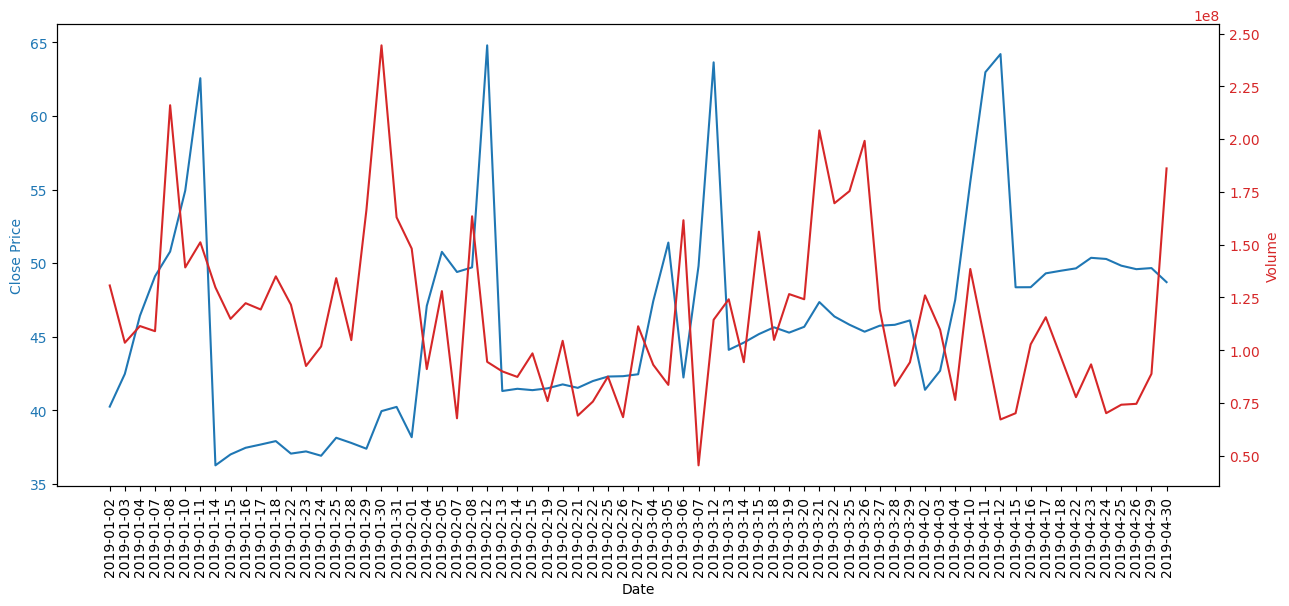

In [ ]:
# Generate a lineplot tracking Close price and Volume over time
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot Close price on the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(stock_daily.index, stock_daily['Close'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.tick_params(axis='x', rotation=90)

# Create a secondary y-axis for Volume
ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:red')
ax2.plot(stock_daily.index, stock_daily['Volume'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.show()

**Observations**

* The lineplot does not demonstrate a direct correlation between trading volume and stock close price.
* Stock close price and trading volumes peak on different dates.
* An increase in trading volume does not consistently predict an increase or decreate in stock close price on the following days.

#### Label vs Volume

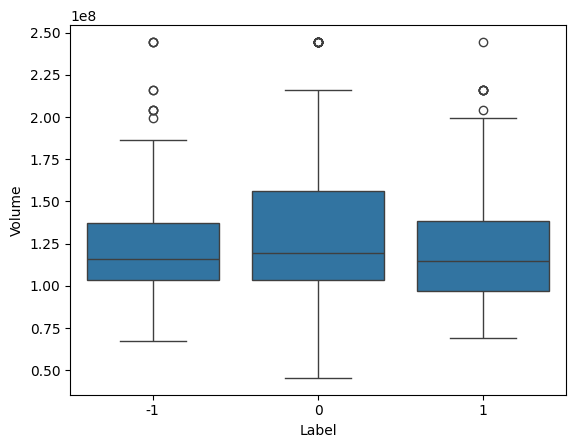

In [ ]:
# Generate a box plot showing the range of trading volumes for each sentiment label
sns.boxplot(data=data, x="Label", y="Volume");

**Observations**
* Excluding outliers, trading volume does not exceed `2.0\*10^8` on days where either positive or negative news stories are published, but can be higher on days where neutral sentiment news stories are published.
  * This suggests there may be more speculative trading on days where there is no clear sentiment to the news stories being published.
* There are outliers in trading volume exceeding the majority of trading days for all sentiments. These outliers can reach as high as `2.5\*10^8` in daily trading volume.

## **Data Preprocessing**

###Step 1 - Convert Date field to datetime objects

In [ ]:
# Show data type of Date field in data set
print(data['Date'].dtype)

object


In the original data set, the **Date** value is stored as an object variable. To assist with manipulation of this value, it should first be converted to a datetime variable.

In [ ]:
# Convert the Date field to datetime objects
data['Date'] = pd.to_datetime(data['Date'])

# Show new data type of Date field
print(data['Date'].dtype)

datetime64[ns]


The **Date** attribute is now stored as a datetime variable in the data set. This will assist with splitting the data set into training, validation and test sets below.

###Step 5 - Splitting data into test, validation and training data sets

In [ ]:
# Obtain statistical summary of Date and News values in data set
data[["Date","News"]].describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max
Date,349,NaN,NaN,NaN,2019-02-16 16:05:30.085959936,2019-01-02 00:00:00,2019-01-14 00:00:00,2019-02-05 00:00:00,2019-03-22 00:00:00,2019-04-30 00:00:00
News,349,349,The tech sector experienced a significant dec...,1,NaN,NaN,NaN,NaN,NaN,NaN


The data set is made up of 349 unique news stories published over 71 trading dates. As the stock Open, Low, High and Close price values are identical for all records on a specific date, the splitting of the original data set into training, validation and test sets should be based on date.

In [ ]:
# Calculate the 60th, 80th, and 100th percentiles of the 'Date' column
date_percentiles = data['Date'].quantile([0.8, 0.9, 1.0])

# Print the results
date_percentiles

,Date
0.8,2019-03-27
0.9,2019-04-17
1.0,2019-04-30


As this is a small data set, news stories which fall on of before the 80% date percentile will be selected as training data. This larger training data set was selected to reduce the risk of overfitting due to insufficient training data.

News stories which fall after the 80th percentile date but on or before the 90th percentile date will be selected as validation data.

All remaining news stories will be reserved for use as test data.

In [ ]:
# Generate training, validation and test data sets using news stories published betweem the date percentiles identified
X_train = data[(data['Date'] <= date_percentiles[0.8])].reset_index()
X_val = data[(data['Date'] > date_percentiles[0.8]) & (data['Date'] <= date_percentiles[0.9])].reset_index()
X_test = data[data['Date'] > date_percentiles[0.9]].reset_index()

Once the data has been split into training, validation and test data sets, the target **Label** variable will be exported from the predictor variables for each data set.

In [ ]:
# Export Label variable from each data set into a separate data set
y_train = X_train['Label']
y_val = X_val['Label']
y_test = X_test['Label']

# Remove target variable from predictor variables in each data set
X_train = X_train.drop('Label', axis=1)
X_val = X_val.drop('Label', axis=1)
X_test = X_test.drop('Label', axis=1)

The shape of the training, validation and test data sets and label sets is displayed below.

In [ ]:
# Display shape of data sets containing the independent variables for each data set
print("Training data set shape: ",X_train.shape)
print("Validation data set shape: ",X_val.shape)
print("Test data set shape: ",X_test.shape)
print("*" * 20)
# Display shape of label sets containing the dependent variables for each data set
print("Training label set shape: ",y_train.shape)
print("Validation label set shape: ",y_val.shape)
print("Test label set shape: ",y_test.shape)

Training data set shape:  (282, 9)
Validation data set shape:  (38, 9)
Test data set shape:  (29, 9)
********************
Training label set shape:  (282,)
Validation label set shape:  (38,)
Test label set shape:  (29,)


## **Word Embeddings**

Before sentiment analysis can be performed on the news stories in the data set, the words must be converted into numerical vectors by a word embedding model. There are several word embedding models available, that use different methods for representing words as vectors for the purposes of natural language processing.

###Word2Vec

Word2Vec is a technique that uses neural networks to encode words. It takes into account the context of each word to help determine the meaning of the word, and cluster words with similar meanings together in the vector space.

The first step in using Word2Vec is to assemble a list of words from the preprocessed News articles in the data set, and feed this into the Word2Vec model.

In [ ]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in data['News'].values]

In [ ]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 4682


Using the list of words provided from the preprocessed News articles, the Word2Vec model has generated a vocabulary of 3,379 words. Each word will have a unique vector which will form the basis for further processing.

A few examples are shown below.

In [ ]:
# Checking the embedding of the word "stock"
model_W2V.wv["stock"]

array([ 0.0031548 ,  0.04408154,  0.00540048,  0.02411207, -0.00307925,
       -0.05063488,  0.03529759,  0.08445615,  0.0097073 , -0.01544098,
        0.01162634, -0.02239103,  0.00131296,  0.01210874, -0.0293618 ,
       -0.02543178,  0.02100967, -0.01251079, -0.00224768, -0.01348464,
       -0.02681438,  0.0027856 ,  0.03705439,  0.00751129,  0.01477692,
        0.00610301, -0.04408925,  0.00647067, -0.01833992, -0.03531764,
        0.01404814, -0.02160096,  0.00346851, -0.0028749 , -0.00467846,
        0.01697129,  0.01717094, -0.03840523,  0.00191943, -0.01069008,
       -0.01619293, -0.00157434, -0.0017824 , -0.02649756,  0.01592967,
        0.04016516,  0.00028267,  0.01057382, -0.00178734,  0.02725341,
        0.02027254,  0.00525487, -0.01641366,  0.01307483, -0.01071445,
        0.02754299,  0.01355354,  0.00376947,  0.01580434, -0.00473029,
       -0.00667307, -0.01619424, -0.00019841,  0.01074323,  0.00649736,
        0.01450133,  0.00182612,  0.01479243, -0.0227108 , -0.00

In [ ]:
# Checking the embedding of the word "appl"
model_W2V.wv["Apple"]

array([ 0.00365223,  0.05961743,  0.00234654,  0.03684396, -0.0102816 ,
       -0.0626196 ,  0.05051035,  0.11398998,  0.01137601, -0.01470604,
        0.01563994, -0.03055768,  0.00269301,  0.01220307, -0.03589439,
       -0.03738506,  0.03277431, -0.01693231,  0.00100917, -0.01510651,
       -0.0333977 , -0.00199263,  0.04809157,  0.01133749,  0.02201956,
        0.00497672, -0.06009248,  0.00839956, -0.02468395, -0.05356184,
        0.01455913, -0.02463618,  0.00663813, -0.00378883, -0.00870215,
        0.02169966,  0.02728098, -0.04838062, -0.00368447, -0.01005492,
       -0.02595858, -0.00140902,  0.00410508, -0.03572866,  0.01990624,
        0.05075385, -0.00261685,  0.01656421, -0.00421089,  0.04274576,
        0.02391667,  0.01248962, -0.02536199,  0.01148019, -0.01283836,
        0.03087251,  0.02256313,  0.00553788,  0.02216704, -0.00615911,
       -0.01310016, -0.01987178, -0.00148031,  0.01034286,  0.00707094,
        0.0176224 , -0.00288353,  0.02750332, -0.0296717 , -0.01

Words that are similar in semantic meaning will have vector embedding values with a high cosine similarity, signaling they are located close together in the vector space.

In [ ]:
# Checking top 5 similar words to the word 'apple'
model_W2V.wv.similar_by_word('Apple', topn=5)

[('the', 0.9980044960975647),
 ('to', 0.9979519248008728),
 ('a', 0.997875452041626),
 ('and', 0.997866690158844),
 ('of', 0.9977622628211975)]

Now that the Word2Vec model has generated an embedding for each word in the vocabulary, the words and their corresponding vectors can be paired together in a dictionary.

In [ ]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

This dictionary can then be applied to each preprocessed news story in each data set to generate a vector representation of each news story. This vector representation is simply an average of the vector representations of each individual word in the news story.

In [ ]:
# Defining a function to generate a feature vector using Word2Vec for each news story
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# Applying the function to each preprocessed news story in the data sets
start = time.time()

X_train_wv = pd.DataFrame(X_train["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  0.9347774982452393


In [ ]:
# Output the shape of the data sets after encoding with the Word2Vec model
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(282, 300) (38, 300) (29, 300)


Each record in the training, validation and test data sets has been converted into a 300-element vector based on encoding the words in each preprocessed news story using the Word2Vec model. These encodings will be used to train the sentiment analysis model.

###GloVe

GloVE, short for "Global Vectors for Word Representation" is another word embedding model which can be used to encode language for further processing. It differs from Word2Vec by considering the global context of each word across the entire corpus, rather than just the local context of each word.

In [ ]:
# Load the Stanford GloVe model
filename = '/content/drive/MyDrive/Study_Materials/PGP-AIML/06.Natural_Language_Processing/Project_7_Stock_Market_Sentiment_Analysis/glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


Rather than generating a vocabulary of word embeddings from words present in the data set, the GloVe model relies on a predefined vocabulary of 400,000 words which is loaded into the model.

A few examples are shown below.

In [ ]:
# Checking the word embedding of a random word
glove_model["stock"]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [ ]:
# Checking the word embedding of a random word
glove_model["apple"]

array([-0.5985   , -0.46321  ,  0.13001  , -0.019576 ,  0.4603   ,
       -0.3018   ,  0.8977   , -0.65634  ,  0.66858  , -0.49164  ,
        0.037557 , -0.050889 ,  0.6451   , -0.53882  , -0.3765   ,
       -0.04312  ,  0.51384  ,  0.17783  ,  0.28596  ,  0.92063  ,
       -0.49349  , -0.48583  ,  0.61321  ,  0.78211  ,  0.19254  ,
        0.91228  , -0.055596 , -0.12512  , -0.65688  ,  0.068557 ,
        0.55629  ,  1.611    , -0.0073642, -0.48879  ,  0.45493  ,
        0.96105  , -0.063369 ,  0.17432  ,  0.9814   , -1.3125   ,
       -0.15801  , -0.54301  , -0.13888  , -0.26146  , -0.3691   ,
        0.26844  , -0.24375  , -0.19484  ,  0.62583  , -0.7377   ,
        0.38351  , -0.75004  , -0.39053  ,  0.091498 , -0.36591  ,
       -1.4715   , -0.45228  ,  0.2256   ,  1.1412   , -0.38526  ,
       -0.06716  ,  0.57288  , -0.39191  ,  0.31302  , -0.29235  ,
       -0.96157  ,  0.15154  , -0.21659  ,  0.25103  ,  0.096967 ,
        0.2843   ,  1.4296   , -0.50565  , -0.51374  , -0.4721

Similarly to the Word2Vec model, in order to use the predefined embeddings provided with the GloVe model, each word and their corresponding vectors need to be compiled into a dictionary.

In [ ]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

This dictionary can then be applied to each preprocessed news story in each data set to generate a vector representation of each news story.

In [ ]:
# Setting vector size for feature embeddings to be generated using GloVe
vec_size=100

# Defining a function to generate a feature vector using GloVe for each news story
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# Applying the function to each preprocessed news story in the data sets
start = time.time()

X_train_gl = pd.DataFrame(X_train["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_gl = pd.DataFrame(X_val["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_gl = pd.DataFrame(X_test["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
end = time.time()

print('Time taken ', (end-start))

Time taken  31.880350589752197


In [ ]:
# Output the shape of the data sets after encoding with the GloVe model
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape)

(282, 100) (38, 100) (29, 100)


Each record in the training, validation and test data sets has been converted into a 100-element vector based on encoding the words in each preprocessed news story using the GloVe model. These encodings will be used to train the sentiment analysis model.

###Sentence Transformer

Sentence Transformers are a type of neural network architecture which can be used to generate embeddings of entire sentences, rather than generating an embedding for each individual word like Word2Vec and GloVe do. It utilizes transformer models with self-attention mechanisms to allow it to understand the relationships between words in a sentence.

This helps the model to understand and represent overall sentiment of a sentence, without the need to encode each individual word within the sentence.

In [ ]:
# Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Like GloVe, the SentenceTransformer process makes use of predefined models in order to generate sentence embeddings.

However, there is no need to create a dictionary of individual words and word embeddings to apply to the data set like was performed with Word2Vec and GloVe. Once downloaded, the model can be applied directly to the news stories to generate an embedding.

In [ ]:
# Setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# encoding the dataset
start = time.time()

X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device=device)
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device)
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device)

end = time.time()
print("Time taken ",(end-start))

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Time taken  3.6419527530670166


In [ ]:
# Output the shape of the data sets after encoding with the SentenceTransformer model
print(X_train_st.shape, X_val_st.shape, X_test_st.shape)

(282, 384) (38, 384) (29, 384)


Each record in the training, validation and test data sets has been converted into a 384-element vector based on encoding the words in each preprocessed news story using the SentenceTransformer model. These encodings will be used to train the sentiment analysis model.

## **Sentiment Analysis**

###Model Evaulation Criteria

**In this scenario, the model can make wrong predictions if:**

* It incorrectly identifies a **Negative** sentiment story as either **Neutral** or **Positive** sentiment.
* It incorrectly identifies a **Neutral** sentiment story as either **Negative** or **Positive** sentiment.
* It incorrectly identifies a **Positive** sentiment story as either **Neutral** or **Negative** sentiment.

**Which case is more important?**

* If the model incorrectly identifies a news story as **Positive**, it may cause a financial analyst to make an inappropriate purchase of stock, leading to financial loss.
* If the model incorrectly identifies a news story as **Negative**, it may trigger the premature sale of stock, leading to a reduction in potential profit.
* There is no clear impact on incorrectly identifying a news story as **Neutral** - this may instead rely on the judgement of the financial analyst, and the nature of the news story.

**Which model evaluation criteria to use?**

As this is an unbalanced data set with regard to the **Label** target variable, Accuracy is not an appropriate performance metric.

Instead, the **F1-score** may be a more appropriate metric, as it combines both the Precision and Recall performance metrics into a single value.

###Model Evaluation Functions

The functions below have been provided to expedite the model evaulation process.

In [ ]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [ ]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

### Base Model - Word2Vec

An initial model will be fit on the training data encoded with Word2Vec using the **GradientBoostingClassifer** model.

This model was selected for its ability to perform accurate predictions on complex and imbalanced data sets. It will also benefit from hyperparameter tuning once the initial classifier model is established.

In [ ]:
# Building the model
base_wv = GradientBoostingClassifier(random_state = 42)

# Fitting on train data
base_wv.fit(X_train_wv, y_train)

GradientBoostingClassifier(random_state=42)

####Training performance

The performance of the classifier on the encoded training data is illustrated using the confusion matrix below.

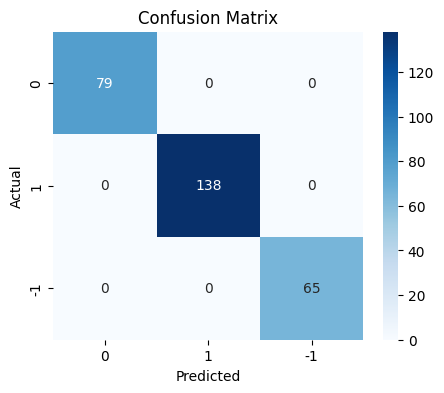

In [ ]:
# Generate confusion matrix on performance of base model predicting sentiment on Word2Vec embedded training data set
plot_confusion_matrix(base_wv,X_train_wv,y_train)

In [ ]:
# Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


**Observations**
* The model predicted 100% of sentiment values on the training data set correctly. This suggests some overfitting may be occurring.

####Validation performance

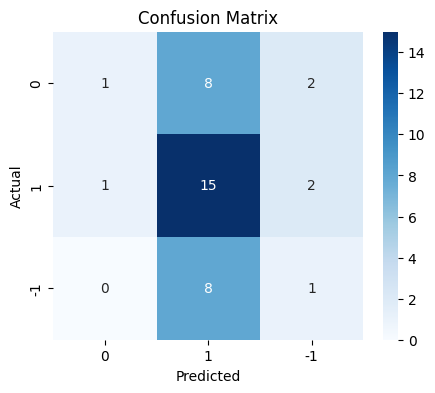

In [ ]:
# Generate confusion matrix on performance of base model predicting sentiment on Word2Vec embedded validation data set
plot_confusion_matrix(base_wv,X_val_wv,y_val)

In [ ]:
# Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n", base_val_wv)

Validation performance:
    Accuracy    Recall  Precision       F1
0  0.447368  0.447368   0.421307  0.36838


**Observations**
* The model achieved an F1 score of 0.31, lower than the perfect F1 score achieved on the training data set.
* The model accurately predicted the sentiment on less than half of the records in the validation data set.
* This suggests the model is overfitting, and requires significant parameter tuning to be effective when using the Word2Vec embedded data.

### Base Model - GloVe

An initial model will be fit on the training data encoded with GloVe, again using the **GradientBoostingClassifer** model for consistency.

In [ ]:
# Building the model
base_gl = GradientBoostingClassifier(random_state = 42)

# Fitting on train data
base_gl.fit(X_train_gl, y_train)

GradientBoostingClassifier(random_state=42)

####Training performance

The performance of the classifier on the encoded training data is illustrated using the confusion matrix below.

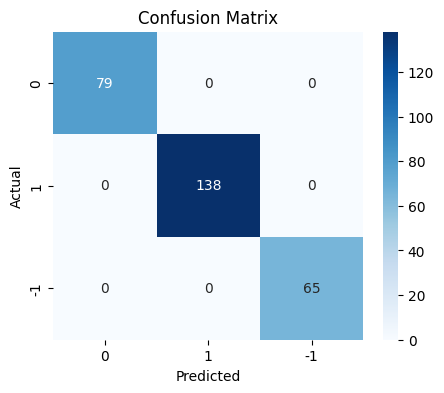

In [ ]:
# Generate confusion matrix on performance of base model predicting sentiment on GloVe embedded training data set
plot_confusion_matrix(base_gl,X_train_gl,y_train)

In [ ]:
# Calculating different metrics on training data
base_train_gl = model_performance_classification_sklearn(base_gl,X_train_gl,y_train)
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


**Observations**
* As with the Word2Vec encoded data, the model predicted 100% of sentiment values on the training data encoded with GloVe correctly. This suggests overfitting is occurring.

####Validation performance

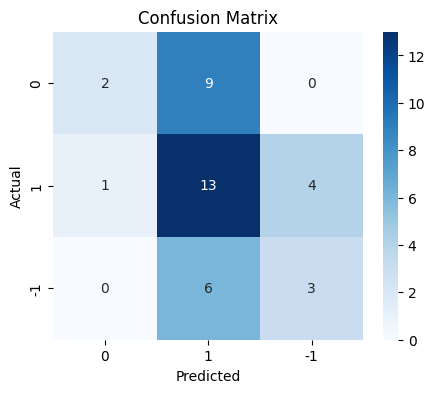

In [ ]:
# Generate confusion matrix on performance of base model predicting sentiment on GloVe embedded validation data set
plot_confusion_matrix(base_gl,X_val_gl,y_val)

In [ ]:
# Calculating different metrics on validation data
base_val_gl = model_performance_classification_sklearn(base_gl,X_val_gl,y_val)
print("Validation performance:\n", base_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.473684  0.473684   0.514411  0.439257


**Observations**
* The model achieved an F1 score of 0.46, higher than that achieved by the GradientBoostingClassifier model trained on data encoded with Word2Vec.
* The F1 score is still lower than the perfect F1 score achieved on the training data set encoded with GloVe.
* The model accurately predicted the sentiment on more than half of the records in the validation data set.
* This suggests the model is overfitting, but to a lesser degree than the classifier model trained on Word2Vec data. It requires significant parameter tuning to be effective when using the GloVe embedded data.

### Base Model - Sentence Transformer

An initial model will be fit on the training data encoded with SentenceTransformer, again using the **GradientBoostingClassifer** model for consistency.

In [ ]:
# Building the model
base_st = GradientBoostingClassifier(random_state = 42)

# Fitting on train data
base_st.fit(X_train_st, y_train)

GradientBoostingClassifier(random_state=42)

####Training performance

The performance of the classifier on the encoded training data is illustrated using the confusion matrix below.

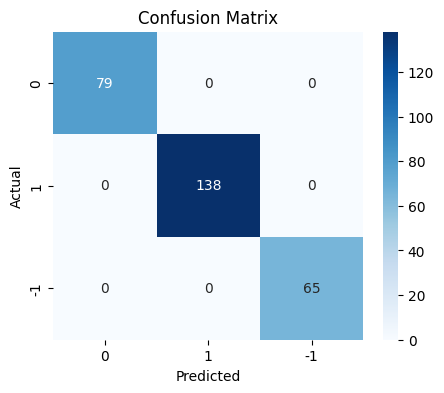

In [ ]:
# Generate confusion matrix on performance of base model predicting sentiment on Sentence Transformer embedded training data set
plot_confusion_matrix(base_st,X_train_st,y_train)

In [ ]:
# Calculating different metrics on training data
base_train_st = model_performance_classification_sklearn(base_st,X_train_st,y_train)
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


**Observations**
* As with the previous 2 models, the model predicted 100% of sentiment values on the training data encoded with Sentence Transformer correctly. This suggests overfitting is occurring.

####Validation performance

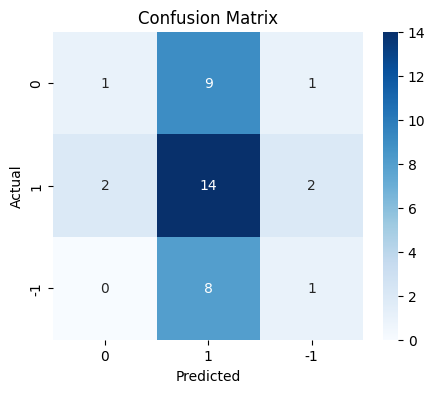

In [ ]:
# Generate confusion matrix on performance of base model predicting sentiment on Sentence Transformer embedded validation data set
plot_confusion_matrix(base_st,X_val_st,y_val)

In [ ]:
# Calculating different metrics on validation data
base_val_st = model_performance_classification_sklearn(base_st,X_val_st,y_val)
print("Validation performance:\n", base_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.421053  0.421053   0.369624  0.348467


**Observations**
* The model achieved an F1 score of 0.34, lower than that achieved by the GradientBoostingClassifier model trained on data encoded with GloVe.
* The model accurately predicted the sentiment on approximately half of the records in the validation data set.
* This suggests the model is overfitting. It requires significant parameter tuning to be effective when using the Sentence Transformer embedded data.

### Tuned Model - Word2Vec

In order to improve the performance of the **GradientBoostingClassifer** model, hyperparameter tuning can be performed. A range of hyperparameters can be set, and the most optimal configuration selected based on model performance against the chosen performance metric.

First, hyperparameter tuning will be performed using the news stories encoded with Word2Vec. As there is a wide range of hyperparameters to optimize for GradientBoostingClassifier model, the hyperparameter space will be searched using **HalvingRandomizedSearchCV**.

In [ ]:
# Test a range of hyperparameters for GradientBoosting to determine most optimal hyperparameters
start = time.time()

# Instantiating GradientBoosting model
gbc = GradientBoostingClassifier(random_state = 42)

parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    "subsample":[0.7,0.9],
    "max_features":[0.5,0.7,1]
}

gb_random_wv = HalvingRandomSearchCV(
    estimator = gbc,
    param_distributions = parameters,
    factor = 2,
    verbose = 2,
    n_jobs = -1,
    scoring='f1_weighted',
    cv=5,
    random_state = 42)

gb_random_wv.fit(X_train_wv, y_train)

end = time.time()
print("Best Parameters:", gb_random_wv.best_params_)
print("Best F1 Score:", gb_random_wv.best_score_)
print("Time taken ",(end-start))

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 30
max_resources_: 282
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 30
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 5
n_resources: 60
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 3
n_resources: 120
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 240
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 300, 'max_features': 0.7, 'max_depth': 7, 'learning_rate': 0.1}
Best F1 Score: 0.46282060687097387
Time taken  244.16052556037903


In [ ]:
# Set the tuned model to the best combination of parameters
tuned_wv = gb_random_wv.best_estimator_

In [ ]:
# Fit the tuned model to the training data
tuned_wv = tuned_wv.fit(X_train_wv, y_train)

####Training performance

The performance of the tuned classifier on the encoded training data is illustrated using the confusion matrix below.

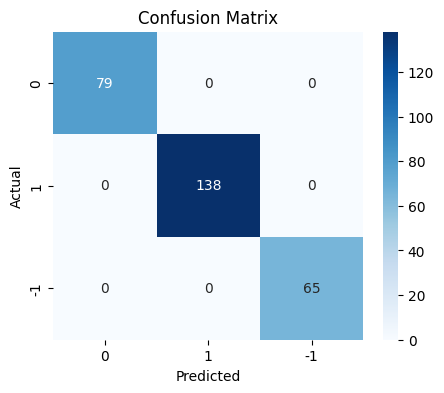

In [ ]:
# Generate confusion matrix on performance of tuned model predicting sentiment on Word2Vec embedded training data set
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

In [ ]:
# Calculating different metrics on training data
tuned_train_wv = model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n", tuned_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0



**Observations**
* Like the base model, the tuned model predicted 100% of sentiment values on the training data set correctly. This suggests some overfitting may be occurring.

####Validation performance

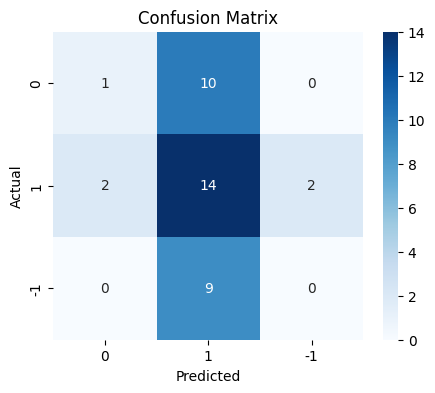

In [ ]:
# Generate confusion matrix on performance of tuned model predicting sentiment on Word2Vec embedded validation data set
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

In [ ]:
# Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n", tuned_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.394737  0.394737   0.297448  0.301415


**Observations**
* The model achieved a lower F1 score of 0.30, suggesting that the method of hyperparameter training used was ineffective.

### Tuned Model - GloVe

Hyperparameter tuning will now be performed on the Classifier model trained using data encoded with GloVe.

In [ ]:
# Test a range of hyperparameters for GradientBoosting to determine most optimal hyperparameters
start = time.time()

# Instantiating GradientBoosting model
gbc = GradientBoostingClassifier(random_state = 42)

parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    "subsample":[0.7,0.9],
    "max_features":[0.5,0.7,1]
}

gb_random_gl = HalvingRandomSearchCV(
    estimator = gbc,
    param_distributions = parameters,
    factor = 2,
    verbose = 2,
    n_jobs = -1,
    scoring='f1_weighted',
    cv=5,
    random_state = 42)

gb_random_gl.fit(X_train_gl, y_train)

end = time.time()
print("Best Parameters:", gb_random_gl.best_params_)
print("Best F1 Score:", gb_random_gl.best_score_)
print("Time taken ",(end-start))

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 30
max_resources_: 282
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 30
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 5
n_resources: 60
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 3
n_resources: 120
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 240
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 300, 'max_features': 0.7, 'max_depth': 7, 'learning_rate': 0.1}
Best F1 Score: 0.46919409187853367
Time taken  211.42395448684692


In [ ]:
# Set the tuned model to the best combination of parameters
tuned_gl = gb_random_gl.best_estimator_

In [ ]:
# Fit the tuned model to the training data
tuned_gl = tuned_gl.fit(X_train_gl, y_train)

####Training performance

The performance of the classifier on the encoded training data is illustrated using the confusion matrix below.

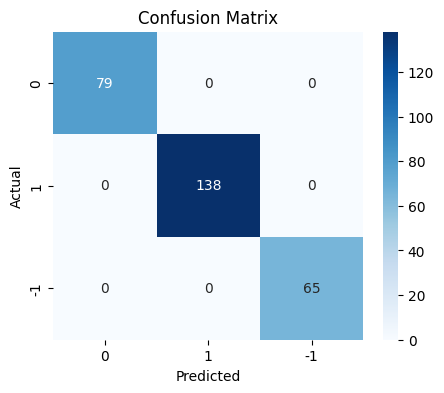

In [ ]:
# Generate confusion matrix on performance of tuned model predicting sentiment on GloVe embedded training data set
plot_confusion_matrix(tuned_gl,X_train_gl,y_train)

In [ ]:
# Calculating different metrics on training data
tuned_train_gl = model_performance_classification_sklearn(tuned_gl,X_train_gl,y_train)
print("Training performance:\n", tuned_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


**Observations**
* As with the base model, the tuned model predicted 100% of sentiment values on the training data encoded with GloVe correctly. This suggests overfitting is occurring.

####Validation performance

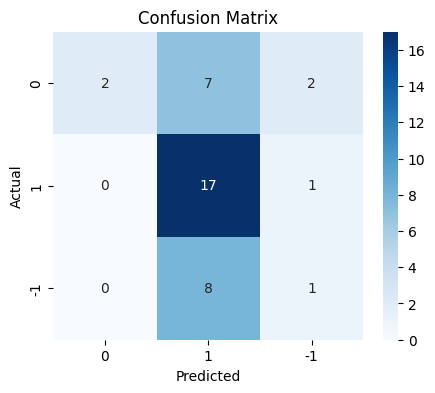

In [ ]:
# Generate confusion matrix on performance of tuned model predicting sentiment on GloVe embedded validation data set
plot_confusion_matrix(tuned_gl,X_val_gl,y_val)

In [ ]:
# Calculating different metrics on validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl,y_val)
print("Validation performance:\n", tuned_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.526316  0.526316   0.600329  0.447611


**Observations**
* The model achieved a lower F1 score of 0.45, suggesting that the method of hyperparameter training used was ineffective.

### Tuned Model - Sentence Transformer

Hyperparameter tuning will now be performed on the Classifier model trained using data encoded with Sentence Transformer.

In [ ]:
# Test a range of hyperparameters for GradientBoosting to determine most optimal hyperparameters
start = time.time()

# Instantiating GradientBoosting model
gbc = GradientBoostingClassifier(random_state = 42)

parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    "subsample":[0.7,0.9],
    "max_features":[0.5,0.7,1]
}

gb_random_st = HalvingRandomSearchCV(
    estimator = gbc,
    param_distributions = parameters,
    factor = 2,
    verbose = 2,
    n_jobs = -1,
    scoring='f1_weighted',
    cv=5,
    random_state = 42)

gb_random_st.fit(X_train_st, y_train)

end = time.time()
print("Best Parameters:", gb_random_st.best_params_)
print("Best F1 Score:", gb_random_st.best_score_)
print("Time taken ",(end-start))

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 30
max_resources_: 282
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 30
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 5
n_resources: 60
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 3
n_resources: 120
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 240
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_features': 0.7, 'max_depth': 7, 'learning_rate': 0.1}
Best F1 Score: 0.4574557637221252
Time taken  489.44486021995544


In [ ]:
# Set the tuned model to the best combination of parameters
tuned_st = gb_random_st.best_estimator_

In [ ]:
# Fit the tuned model to the training data
tuned_st = tuned_st.fit(X_train_st, y_train)

####Training performance

The performance of the classifier on the encoded training data is illustrated using the confusion matrix below.

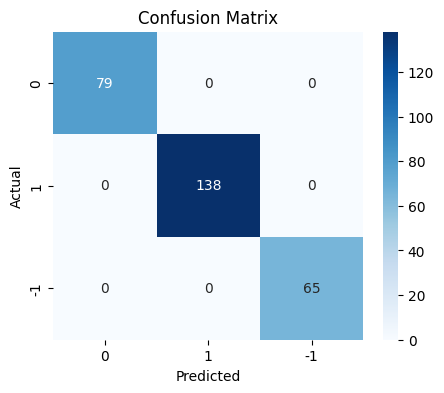

In [ ]:
# Generate confusion matrix on performance of tuned model predicting sentiment on Sentence Transformer embedded training data set
plot_confusion_matrix(tuned_st,X_train_st,y_train)

In [ ]:
# Calculating different metrics on training data
tuned_train_st = model_performance_classification_sklearn(tuned_st,X_train_st,y_train)
print("Training performance:\n", tuned_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


**Observations**
* As with the base model, the tuned model predicted 100% of sentiment values on the training data encoded with Sentence Transformer correctly. This suggests overfitting is occurring.

####Validation performance

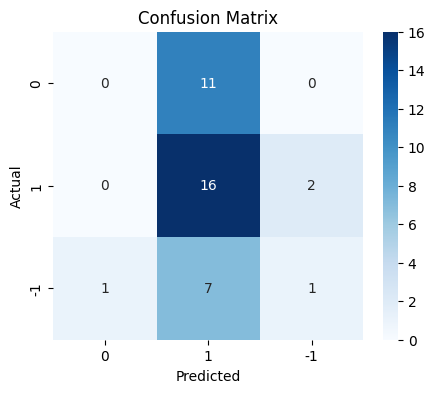

In [ ]:
# Generate confusion matrix on performance of tuned model predicting sentiment on Sentence Transformer embedded validation data set
plot_confusion_matrix(tuned_st,X_val_st,y_val)

In [ ]:
# Calculating different metrics on validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st,y_val)
print("Validation performance:\n", tuned_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.447368  0.447368   0.301858  0.330972


**Observations**
* The model achieved a lower F1 score of 0.33, suggesting that the method of hyperparameter training used was ineffective.

###Model Comparison and Final Model Selection

Now that hyperparameter tuning is complete on 3 models, a final candidate model can be selected based on F1 score performance against the validation data set.

In [ ]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,1.0,1.0,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0,1.0,1.0
F1,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.368421,0.526316,0.447368,0.394737,0.526316,0.447368
Recall,0.368421,0.526316,0.447368,0.394737,0.526316,0.447368
Precision,0.321053,0.555886,0.292105,0.297448,0.600329,0.301858
F1,0.311876,0.464926,0.347368,0.301415,0.447611,0.330972


**Observations**

* The classifer a

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

#### Loading the model

#### Aggregating the data weekly

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

In [ ]:
weekly_grouped

In [ ]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=_____, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=_____, #Complete the code to set the value for temperature.
      top_p=_____, #Complete the code to set the value for top_p
      top_k=_____, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

##### Checking the model output on the weekly data

##### Formatting the model output

## **Conclusions and Recommendations**

-


